In [2]:
import os, sys, glob
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import numpy as np
import scanpy as sc
import scFates as scf

In [3]:
fn = glob.glob('../*/*/*/GSE162534_adata_processed.h5ad')[0]
adata = sc.read_h5ad(fn)

In [4]:
adata

AnnData object with n_obs × n_vars = 8725 × 19013
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

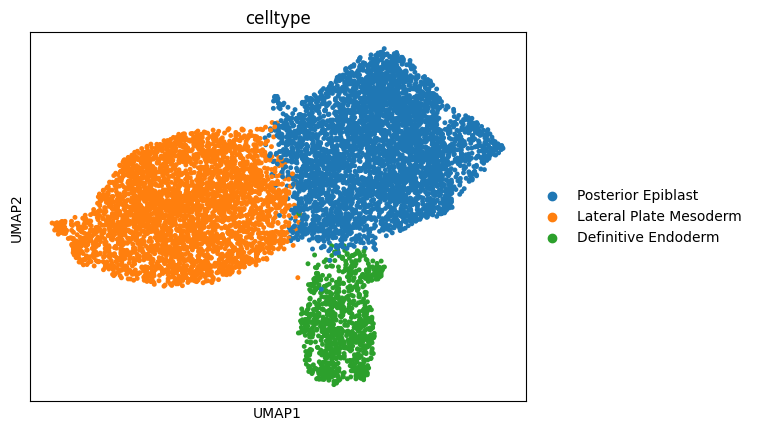

In [5]:
sc.pl.umap(adata, color = 'celltype', size = 50)

In [7]:
adata = adata[(adata.obs.celltype != 'Definitive Endoderm')]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 7817 × 19013
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'celltype_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

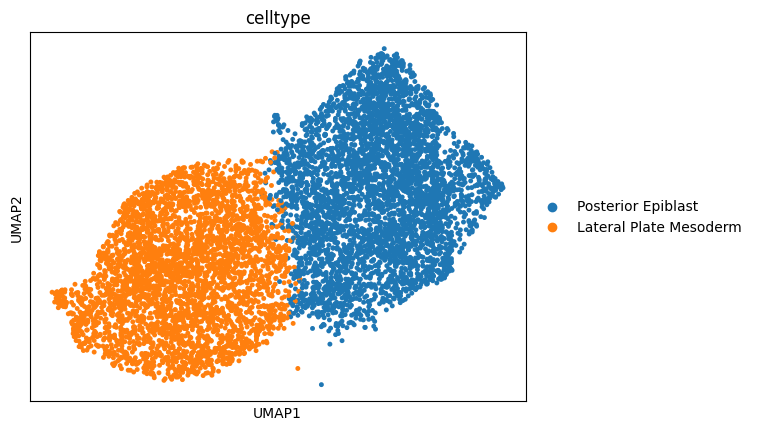

In [9]:
sc.pl.umap(adata, color = 'celltype', size = 50)

inferring a principal curve --> parameters used 
    15 principal points, mu = 100, lambda = 0.01


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scFates/tools/graph_fitting.py:565: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["graph"] = graph


    finished (0:00:02) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


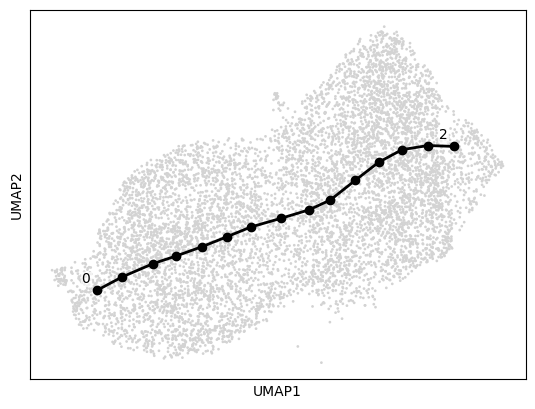

In [10]:
scf.tl.curve(adata, Nodes = 15, epg_lambda = .01, epg_mu = 100, use_rep = 'X_umap', plot = True, basis = 'umap')

In [11]:
scf.tl.root(adata, 2)

node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [12]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


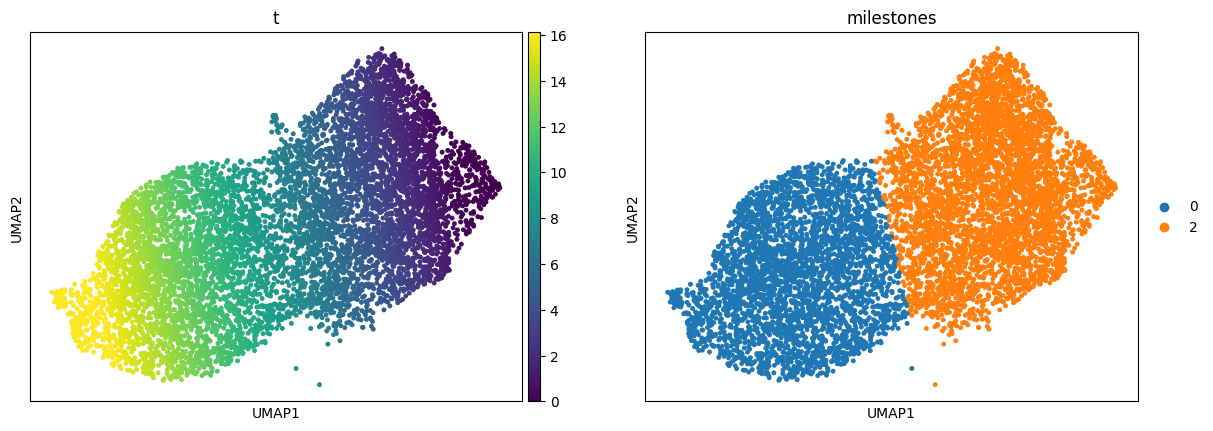

In [13]:
sc.pl.umap(adata, color = ['t', 'milestones'], size = 50)

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


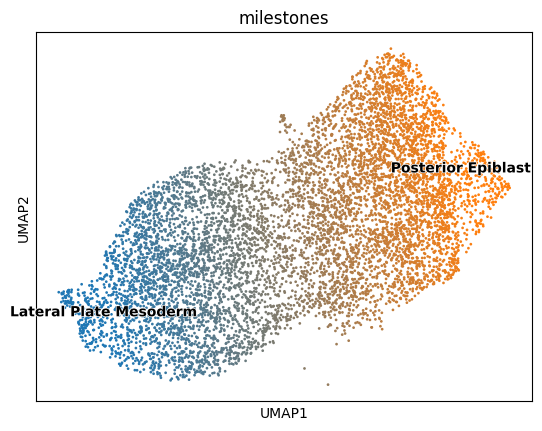

In [14]:
scf.tl.rename_milestones(adata, new = {'0' : 'Lateral Plate Mesoderm', '2' : 'Posterior Epiblast'})
scf.pl.milestones(adata, basis = 'umap', annotate = True)

In [15]:
scf.tl.test_association(adata, n_jobs = 8)

test features for association with the trajectory
    single mapping : 100%|██████████| 19013/19013 [18:17<00:00, 17.33it/s]
    found 219 significant features (0:18:20) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [16]:
scf.tl.fit(adata, n_jobs = 8)

fit features associated with the trajectory
    single mapping : 100%|██████████| 219/219 [00:27<00:00,  8.05it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:29) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


Clustering features using fitted layer
    finished (0:00:01) --> added 
    .var['clusters'] identified modules.
Cluster 0: 72 Genes
Cluster 1: 51 Genes
Cluster 2: 41 Genes
Cluster 3: 30 Genes
Cluster 4: 25 Genes


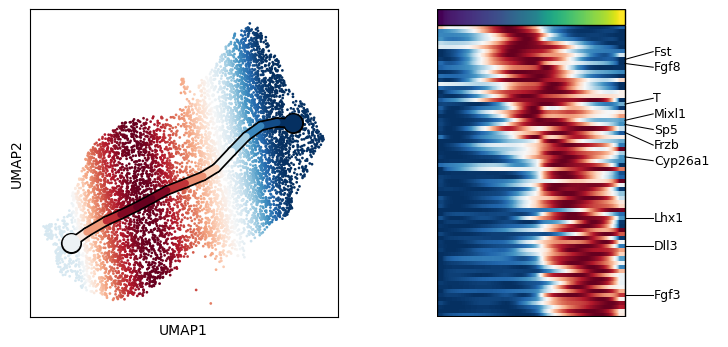

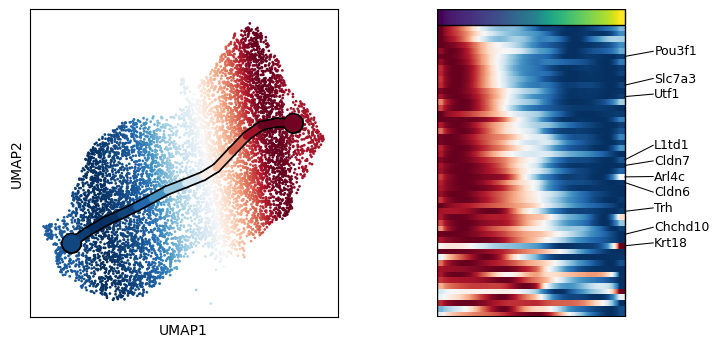

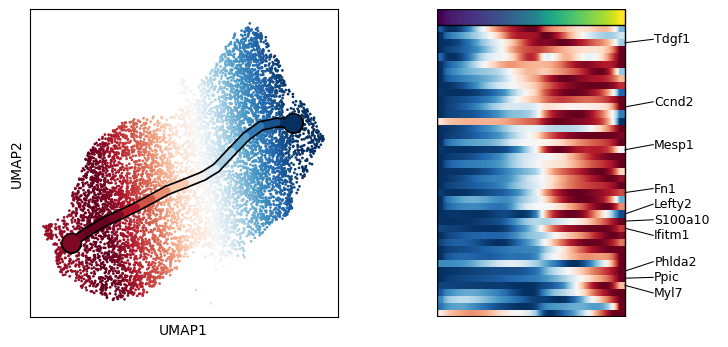

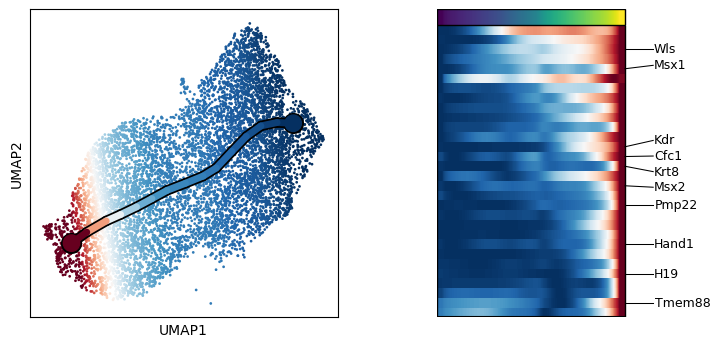

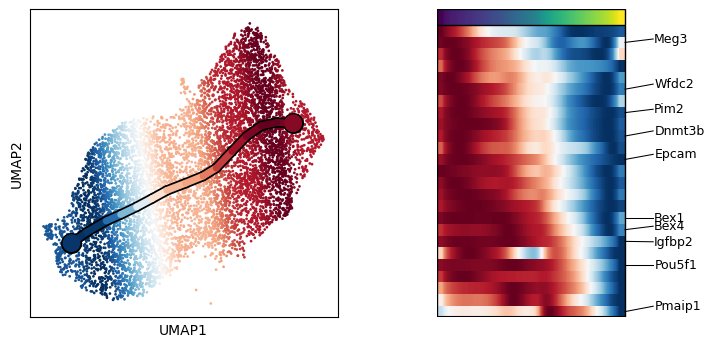

In [22]:
scf.tl.cluster(adata, resolution = .375)
for clus in sorted(adata.var.clusters.unique()):
    clus_msk = (adata.var.clusters == clus)
    clus_features = adata.var_names[clus_msk]
    print(f'Cluster {clus}: {clus_features.size} Genes')
    scf.pl.trends(adata, features = clus_features, basis = 'umap')

late: 143 Genes
early: 76 Genes


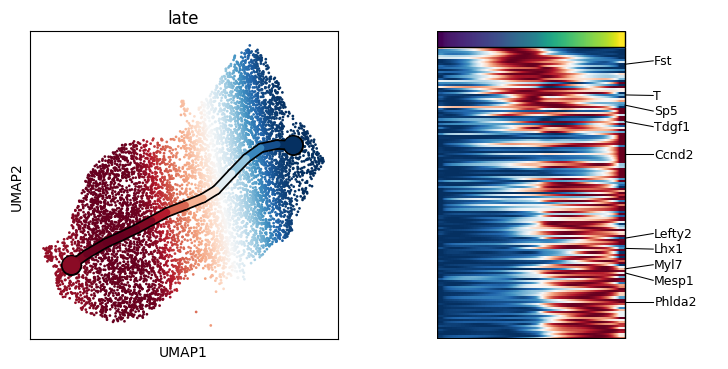

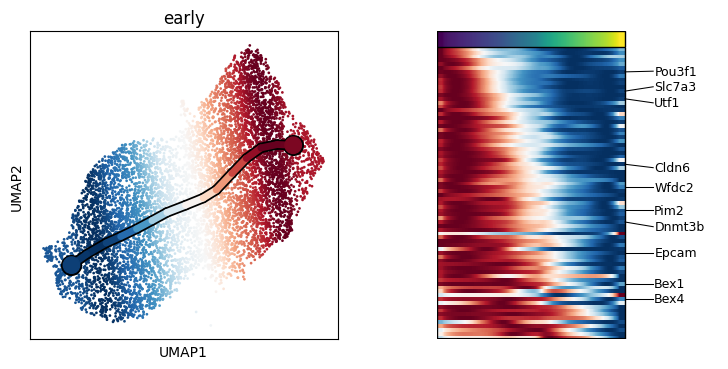

In [23]:
signatures_dict = {
    '0' : 'late',
    '1' : 'early',
    '2' : 'late',
    '3' : 'late',
    '4' : 'early'
    }
adata.var['signature'] = adata.var.clusters.map(signatures_dict).astype('category')
os.mkdir('results/GSE162534')
for clus in adata.var.signature.unique():
    clus_msk = (adata.var.signature == clus)
    clus_features = adata.var_names[clus_msk]
    print(f'{clus}: {clus_features.size} Genes')
    scf.pl.trends(adata, features = clus_features, basis = 'umap', title = clus)
    np.savetxt(f'results/GSE162534/{clus}.txt', clus_features, fmt = '%s')